In [1]:
#%%导入包

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import random
import shap
import sklearn
#（边缘包）
import warnings
import streamlit as st
import pickle
import json

####（边缘函数）
from numpy import argmax
from functools import reduce
from io import StringIO
from collections import Counter
from imblearn.over_sampling import SMOTE,ADASYN,RandomOverSampler

###
from sklearn import svm, datasets,tree,linear_model,metrics
from sklearn.preprocessing import StandardScaler,label_binarize,OrdinalEncoder
from sklearn.ensemble import VotingClassifier,ExtraTreesClassifier,RandomForestClassifier,AdaBoostClassifier,BaggingClassifier,GradientBoostingClassifier
from sklearn.metrics import RocCurveDisplay,roc_auc_score,accuracy_score,roc_auc_score, roc_curve, auc,f1_score,confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import StratifiedKFold,KFold,cross_val_score,train_test_split

from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

from sklearn.inspection import permutation_importance
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.datasets import make_classification,fetch_openml

###
import xgboost
from xgboost.sklearn import XGBClassifier
from xgboost import plot_importance

%matplotlib inline
sns.set(style="darkgrid") #设置seaborn为暗黑风格

In [2]:
random_state_new = 50
jc = 10

In [3]:
import pandas as pd  
  
df1 = pd.read_csv('(PRJNA375935)~97+114.txt', sep='\t')
df2 = pd.read_csv('(PRJEB28545)~113+37.txt', sep='\t')

In [4]:
# # 特征提取与转换
# from sklearn.decomposition import PCA

# pca = PCA(n_components=2)
# X_pca = pca.fit_transform(X)

# X_train, X_test, y_train, y_test = train_test_split(X_pca, y, random_state=random_state_new)

# 划分数据集

In [5]:
X = df1.iloc[:, 2:]
y = df1.iloc[:, 1]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=random_state_new)

In [47]:
y_train

1      0
121    1
178    1
210    1
185    1
      ..
132    1
33     0
109    0
139    1
176    1
Name: label, Length: 158, dtype: int64

In [6]:
# X_train = df1.iloc[:, 2:]  # 选择第三列及以后的所有列（Python是从0开始计数的）  
# y_train = df1.iloc[:, 1]   # 选择第二列

# X_test = df2.iloc[:,2:]
# y_test = df2.iloc[:,1]

# 构建模型

In [7]:
#LR
logis_model = LogisticRegression(random_state=random_state_new,
                                 solver='lbfgs', multi_class='multinomial')
lr_model = logis_model.fit(X_train, y_train)
lr_model_y_prob = lr_model.predict_proba(X_test)

#MLP
mlp_model = MLPClassifier(hidden_layer_sizes=(100,), activation='relu', solver='lbfgs',
                    alpha=0.0001,
                    batch_size='auto',
                    learning_rate='constant',
                    learning_rate_init=1,
                    power_t=0.5,
                    max_iter=200,
                    shuffle=True, random_state=random_state_new)
mlp_model = mlp_model.fit(X_train, y_train)
mlp_model_y_prob = mlp_model.predict_proba(X_test)

#NBC
NBC_model = GaussianNB(var_smoothing=1e-1)
#from sklearn.naive_bayes import BernoulliNB
#model = BernoulliNB()
NBC_model = NBC_model.fit(X_train, y_train)
NBC_model_y_prob = NBC_model.predict_proba(X_test)

#SVC
SVC_model = SVC(kernel='rbf',C=1.0,random_state=random_state_new,probability=True)
SVC_model = SVC_model.fit(X_train, y_train)
SVC_model_y_prob = SVC_model.predict_proba(X_test)

#XGB
xgb_model = XGBClassifier(
    n_estimators=100, max_depth=2, learning_rate=1, random_state=random_state_new)
xgb_model = xgb_model.fit(X_train, y_train)
xgb_model_y_prob = xgb_model.predict_proba(X_test)

#BAG
Bag = BaggingClassifier(KNeighborsClassifier(),
                        max_samples=0.5, max_features=0.5, random_state=random_state_new)
Bag_model = Bag.fit(X_train, y_train)
Bag_model_y_prob = Bag_model.predict_proba(X_test)

#AB
AB = AdaBoostClassifier(n_estimators=10, random_state=random_state_new)
AB_model = AB.fit(X_train, y_train)
AB_model_y_prob = AB_model.predict_proba(X_test)

#GBM
gbm = GradientBoostingClassifier(
    n_estimators=100, learning_rate=1, max_depth=1, random_state=random_state_new)
gbm_model = gbm.fit(X_train, y_train)
gbm_model_y_prob = gbm_model.predict_proba(X_test)

#RF
RF_model = RandomForestClassifier(n_estimators=100, 
                                  random_state=random_state_new)
RF_model = RF_model.fit(X_train, y_train)
RF_model_y_prob = RF_model.predict_proba(X_test)




/home/gg/mambaforge/envs/xiaoli/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/gg/mambaforge/envs/xiaoli/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


# 训练集的十折交叉验证曲线

/home/gg/mambaforge/envs/xiaoli/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/home/gg/mambaforge/envs/xiaoli/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/home/gg/mambaforge/envs/xiaoli/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/home/gg/mambaforge/envs/xiaoli/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME

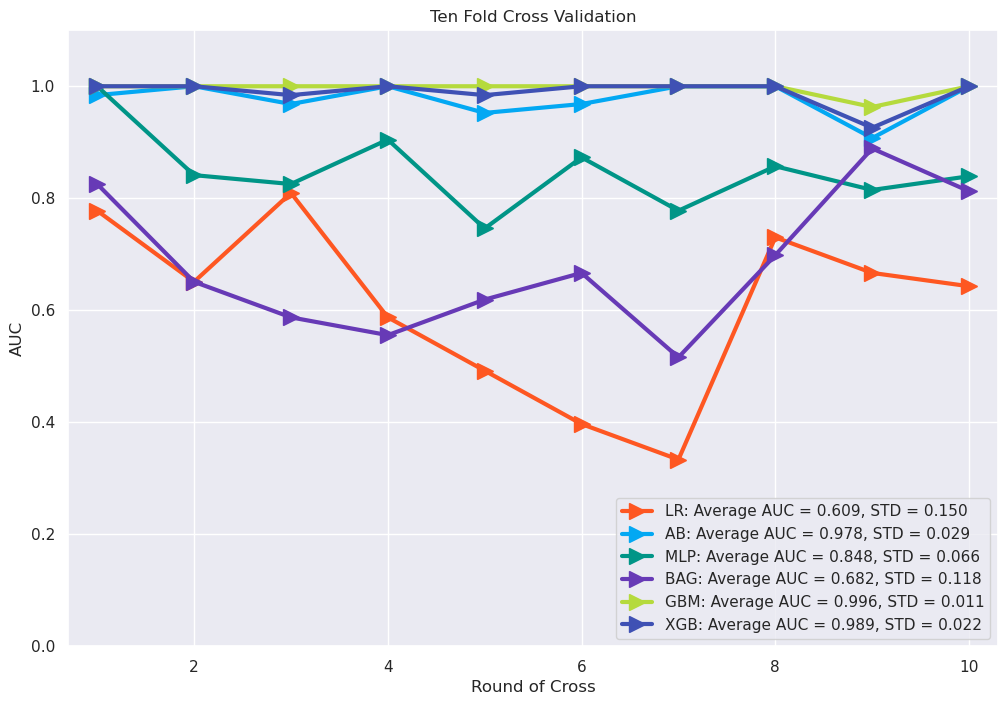

In [25]:
k_folds = 10
strKFold = StratifiedKFold(n_splits=k_folds,shuffle=True,random_state=0)#, test_size=.3)
cv=strKFold

result_lr=cross_val_score(lr_model,X_train,y_train,scoring='roc_auc',cv=cv,n_jobs=-1)
result_ab=cross_val_score(AB_model,X_train,y_train,scoring='roc_auc',cv=cv,n_jobs=-1)
result_bag=cross_val_score(Bag_model,X_train,y_train,scoring='roc_auc',cv=cv,n_jobs=-1)
result_mlp=cross_val_score(mlp_model,X_train,y_train,scoring='roc_auc',cv=cv,n_jobs=-1)
result_gbm=cross_val_score(gbm_model,X_train,y_train,scoring='roc_auc',cv=cv,n_jobs=-1)
result_xgb=cross_val_score(xgb_model,X_train,y_train,scoring='roc_auc',cv=cv,n_jobs=-1)


sns.set()
x = [1, 2, 3, 4, 5,6,7,8,9,10]
fig, ax = plt.subplots(figsize=(12, 8), dpi=100)
plt.plot(x, result_lr, label='LR: Average AUC = {:.3f}, STD = {:.3f}'.format(result_lr.mean(), result_lr.std()),
         linewidth=3, color='#fe5722', marker='>', markerfacecolor='#fe5722', markersize=12)
plt.plot(x, result_ab, label='AB: Average AUC = {:.3f}, STD = {:.3f}'.format(result_ab.mean(), result_ab.std()),
         linewidth=3, color='#03a8f3', marker='>', markerfacecolor='#03a8f3', markersize=12)
plt.plot(x, result_mlp, label='MLP: Average AUC = {:.3f}, STD = {:.3f}'.format(result_mlp.mean(), result_mlp.std()),
         linewidth=3, color='#009587', marker='>', markerfacecolor='#009587', markersize=12)
plt.plot(x, result_bag, label='BAG: Average AUC = {:.3f}, STD = {:.3f}'.format(result_bag.mean(), result_bag.std()),
         linewidth=3, color='#673ab6', marker='>', markerfacecolor='#673ab6', markersize=12)
plt.plot(x, result_gbm, label='GBM: Average AUC = {:.3f}, STD = {:.3f}'.format(result_gbm.mean(), result_gbm.std()),
         linewidth=3, color='#b5da3d', marker='>', markerfacecolor='#b5da3d', markersize=12)
plt.plot(x, result_xgb, label='XGB: Average AUC = {:.3f}, STD = {:.3f}'.format(result_xgb.mean(), result_xgb.std()),
         linewidth=3, color='#3f51b4', marker='>', markerfacecolor='#3f51b4', markersize=12)
ax = plt.gca()
plt.ylim(0.0, 1.1)
plt.xlim(0.7, 10.3)
plt.xlabel('Round of Cross')
plt.ylabel('AUC')
plt.title('Ten Fold Cross Validation')
plt.legend(loc=4)
# plt.show()

plt.savefig("十折交叉验证.pdf",format='pdf')
plt.show()

# 训练集和测试集的ROC曲线

/tmp/ipykernel_1989975/679426868.py:8: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.2980392156862745, 0.4470588235294118, 0.6901960784313725, 1)). The keyword argument will take precedence.
  plt.plot(fpr, tpr, 'b',color=color,label='%s AUC = %0.3f'% (classifiers,roc_auc))
/tmp/ipykernel_1989975/679426868.py:8: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.2980392156862745, 0.4470588235294118, 0.6901960784313725, 1)). The keyword argument will take precedence.
  plt.plot(fpr, tpr, 'b',color=color,label='%s AUC = %0.3f'% (classifiers,roc_auc))
/tmp/ipykernel_1989975/679426868.py:8: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b" (-> color=(0.2980392156862745, 0.4470588235294118, 0.6901960784313725, 1)). The keyword argument will take precedence.
  plt.plot(fpr, tpr, 'b',color=color,label='%s AUC = %0.3f'% (class

<Figure size 2000x1600 with 0 Axes>

<Figure size 2000x1600 with 0 Axes>

<Figure size 2000x1600 with 0 Axes>

<Figure size 2000x1600 with 0 Axes>

<Figure size 2000x1600 with 0 Axes>

<Figure size 2000x1600 with 0 Axes>

<Figure size 2000x1600 with 0 Axes>

<Figure size 2000x1600 with 0 Axes>

<Figure size 2000x1600 with 0 Axes>

<Figure size 2000x1600 with 0 Axes>

<Figure size 2000x1600 with 0 Axes>

<Figure size 2000x1600 with 0 Axes>

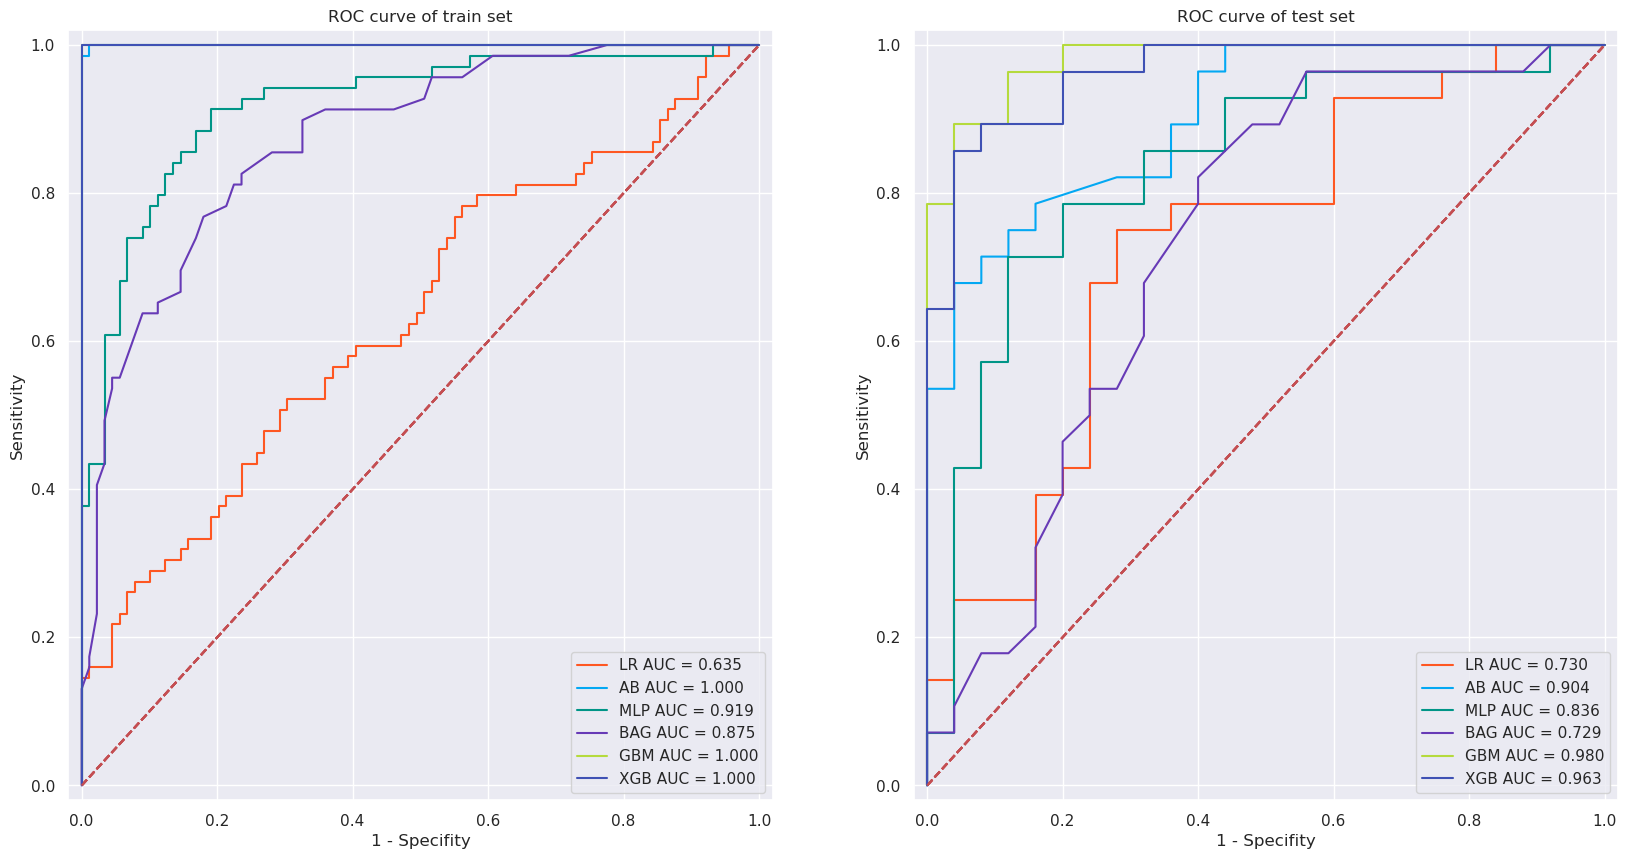

In [26]:
plt.style.use('tableau-colorblind10')
def plot_roc(k,y_pred_undersample_score,labels_test,classifiers,color,title):
    fpr, tpr, thresholds = metrics.roc_curve(labels_test.values.ravel(),y_pred_undersample_score)
    roc_auc = metrics.auc(fpr,tpr)
    plt.figure(figsize=(20,16))
    plt.figure(k)
    plt.title(title)
    plt.plot(fpr, tpr, 'b',color=color,label='%s AUC = %0.3f'% (classifiers,roc_auc))
    plt.legend(loc='lower right')
    plt.plot([0,1],[0,1],'r--')
    plt.xlim([-0.02,1.02])
    plt.ylim([-0.02,1.02])
    plt.ylabel('Sensitivity')
    plt.xlabel('1 - Specifity')
fig = plt.gcf()

plt.rcParams["figure.figsize"] = [20,10]
# fig, ax = plt.subplots(figsize=(12, 8), dpi=100)

plt.subplot(1,2,1)
plot_roc(1,lr_model.predict_proba(X_train)[:,1],pd.DataFrame(y_train),'LR','#fe5722','ROC curve of train set')
plot_roc(1,AB_model.predict_proba(X_train)[:,1],pd.DataFrame(y_train),'AB','#03a8f3','ROC curve of train set')
plot_roc(1,mlp_model.predict_proba(X_train)[:,1],pd.DataFrame(y_train),'MLP','#009587','ROC curve of train set')
plot_roc(1,Bag_model.predict_proba(X_train)[:,1],pd.DataFrame(y_train),'BAG','#673ab6','ROC curve of train set')
plot_roc(1,gbm_model.predict_proba(X_train)[:,1],pd.DataFrame(y_train),'GBM','#b5da3d','ROC curve of train set')
plot_roc(1,xgb_model.predict_proba(X_train)[:,1],pd.DataFrame(y_train),'XGB','#3f51b4','ROC curve of train set')


plt.subplot(1,2,2)
plot_roc(1,lr_model.predict_proba(X_test)[:,1],pd.DataFrame(y_test),'LR','#fe5722','ROC curve of test set')
plot_roc(1,AB_model.predict_proba(X_test)[:,1],pd.DataFrame(y_test),'AB','#03a8f3','ROC curve of test set')
plot_roc(1,mlp_model.predict_proba(X_test)[:,1],pd.DataFrame(y_test),'MLP','#009587','ROC curve of test set')
plot_roc(1,Bag_model.predict_proba(X_test)[:,1],pd.DataFrame(y_test),'BAG','#673ab6','ROC curve of test set')
plot_roc(1,gbm_model.predict_proba(X_test)[:,1],pd.DataFrame(y_test),'GBM','#b5da3d','ROC curve of test set')
plot_roc(1,xgb_model.predict_proba(X_test)[:,1],pd.DataFrame(y_test),'XGB','#3f51b4','ROC curve of test set')
# plt.show()
plt.savefig("训练集-测试集ROC曲线.pdf",format="pdf")
plt.show()

# 训练集-测试集PR曲线

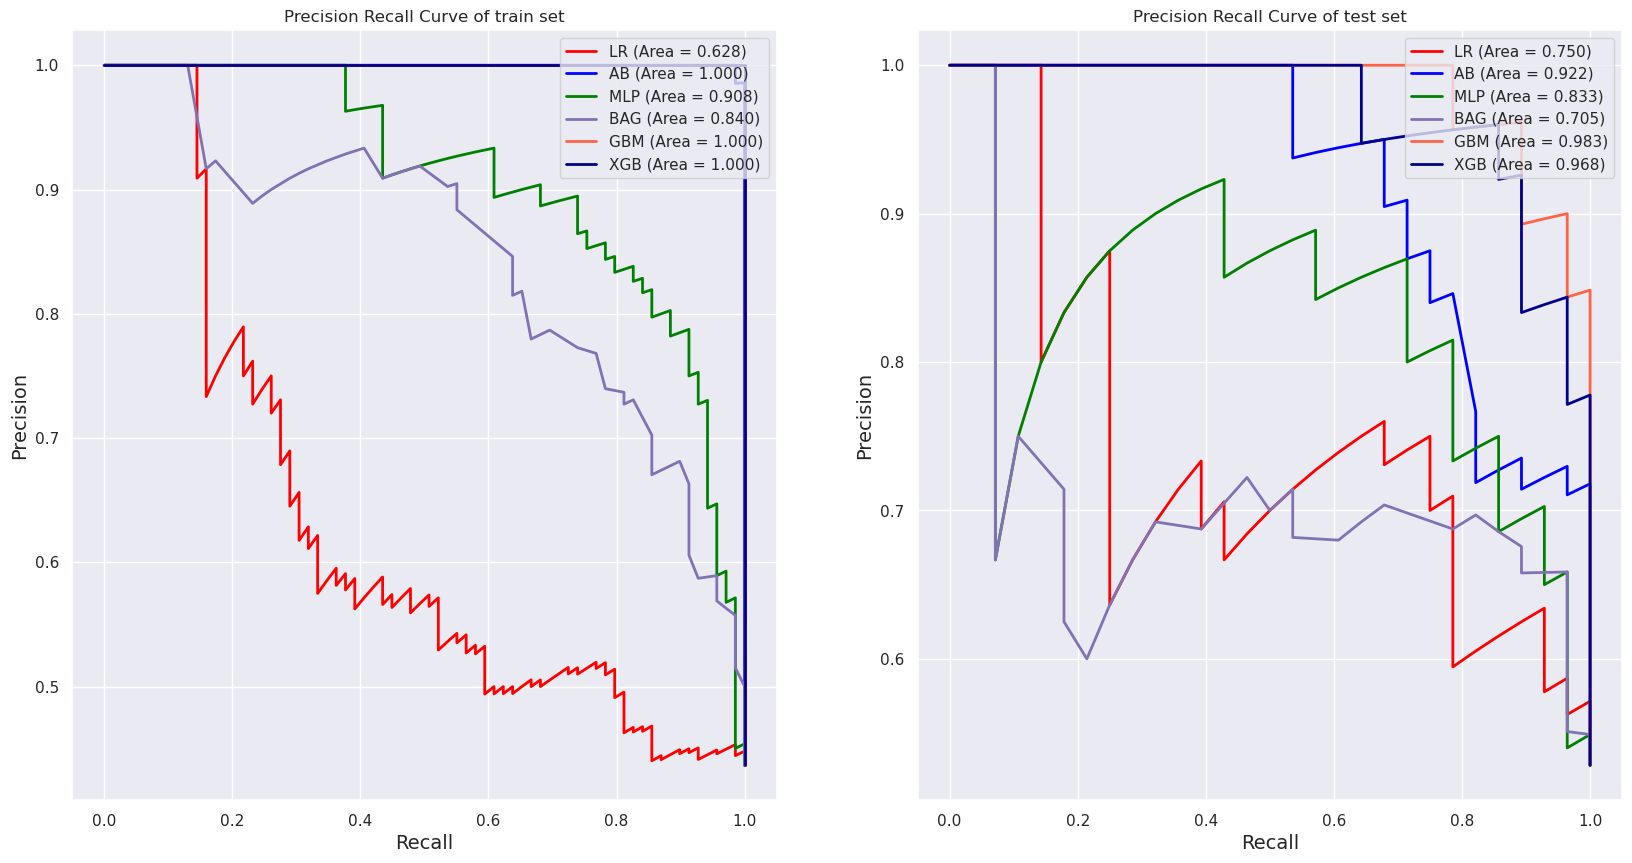

In [27]:
from sklearn.metrics import precision_recall_curve, average_precision_score
def ro_curve(k,y_pred, y_label, method_name,color,title):
    y_label = np.array(y_label)
    y_pred = np.array(y_pred)    
    lr_precision, lr_recall, _ = precision_recall_curve(y_label, y_pred)    
    plt.figure(k)
    plt.plot(lr_recall, lr_precision, lw = 2, label= method_name + ' (Area = %0.3f)' % average_precision_score(y_label, y_pred),color=color)
    fontsize = 14
    plt.xlabel('Recall', fontsize = fontsize)
    plt.ylabel('Precision', fontsize = fontsize)
    plt.title(title)
    plt.legend(loc='upper right')
fig = plt.gcf()

plt.rcParams["figure.figsize"] = [20, 10]
#train 
plt.subplot(1,2,1)
ro_curve(1,lr_model.predict_proba(X_train)[:,1],y_train,'LR','red','Precision Recall Curve of train set')
ro_curve(1,AB_model.predict_proba(X_train)[:,1],y_train,'AB','blue','Precision Recall Curve of train set')
ro_curve(1,mlp_model.predict_proba(X_train)[:,1],y_train,'MLP','green','Precision Recall Curve of train set')
ro_curve(1,Bag_model.predict_proba(X_train)[:,1],y_train,'BAG','m','Precision Recall Curve of train set')
ro_curve(1,gbm_model.predict_proba(X_train)[:,1],y_train,'GBM','tomato','Precision Recall Curve of train set')
ro_curve(1,xgb_model.predict_proba(X_train)[:,1],y_train,'XGB','darkblue','Precision Recall Curve of train set')

#test
plt.subplot(1,2,2)
ro_curve(1,lr_model.predict_proba(X_test)[:,1],y_test,'LR','red','Precision Recall Curve of test set')
ro_curve(1,AB_model.predict_proba(X_test)[:,1],y_test,'AB','blue','Precision Recall Curve of test set')
ro_curve(1,mlp_model.predict_proba(X_test)[:,1],y_test,'MLP','green','Precision Recall Curve of test set')
ro_curve(1,Bag_model.predict_proba(X_test)[:,1],y_test,'BAG','m','Precision Recall Curve of test set')
ro_curve(1,gbm_model.predict_proba(X_test)[:,1],y_test,'GBM','tomato','Precision Recall Curve of test set')
ro_curve(1,xgb_model.predict_proba(X_test)[:,1],y_test,'XGB','darkblue','Precision Recall Curve of test set')


plt.savefig("训练集-测试集PR曲线.pdf",format = "pdf")
plt.show()

# 训练集-测试集校准曲线

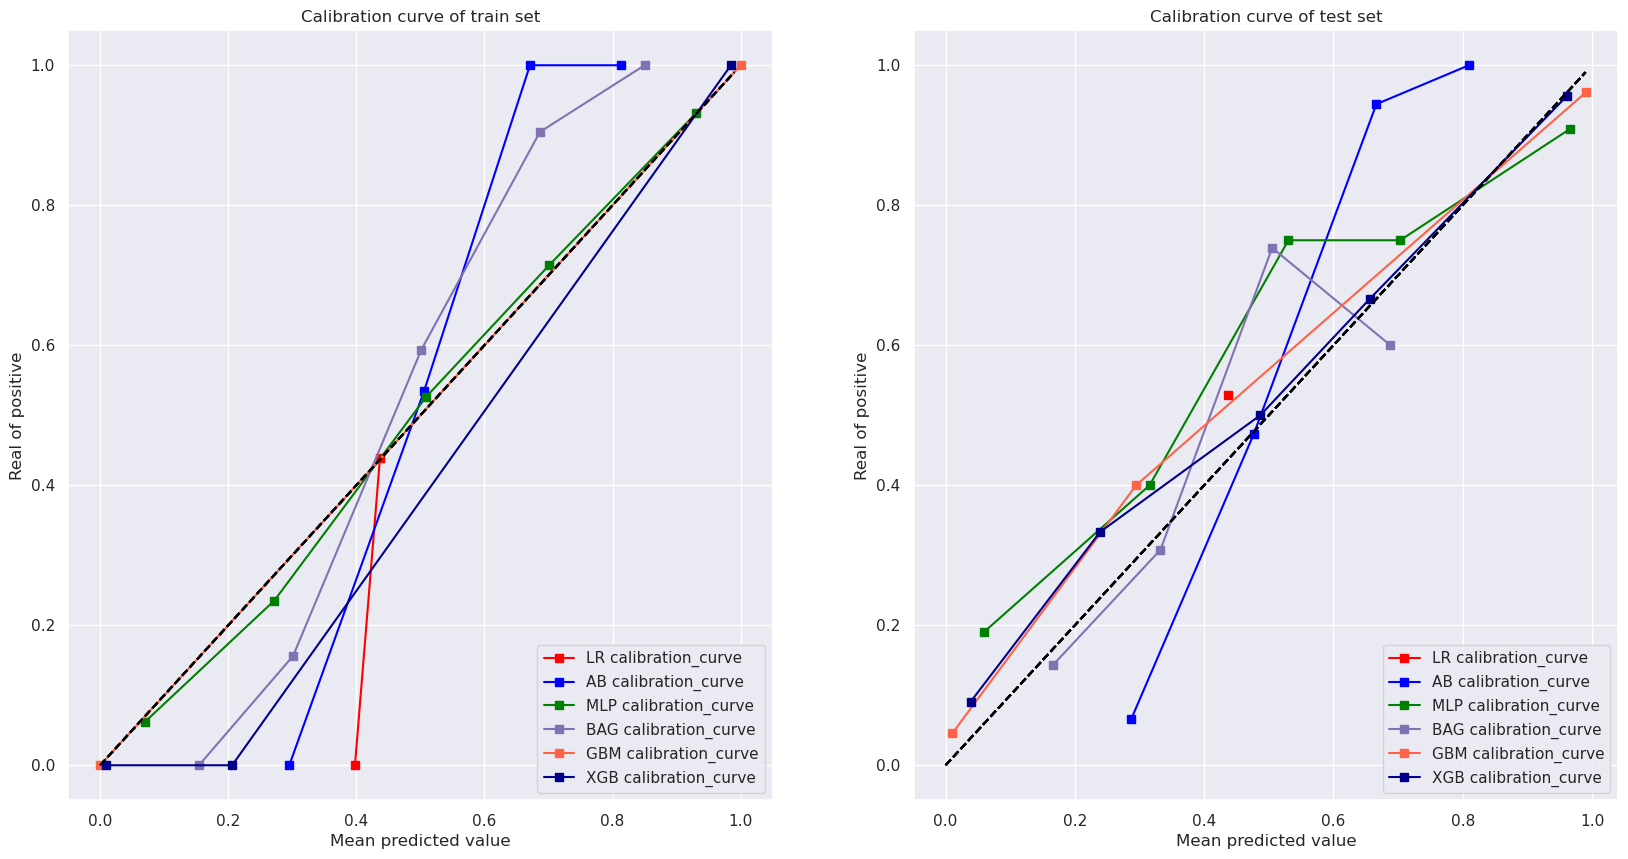

In [28]:
rf_prob = AB_model.predict(X_test)
lr_prob = logis_model.predict(X_test)
dt_prob = Bag_model.predict(X_test)
mlp_prob = mlp_model.predict(X_test)
gbm_prob = gbm_model.predict(X_test)
xgb_prob = xgb_model.predict(X_test)
plt.rcParams["axes.grid"] = False
sns.set()
from sklearn.calibration import calibration_curve
def calibration_curve_1(k,y_pred,y_true,method_name,color,title):
    prob_true, prob_pred = calibration_curve(y_true, y_pred, n_bins=5)
    plt.figure(k)
    plt.plot(prob_pred,prob_true,color=color,label='%s calibration_curve'%method_name,marker='s')
    plt.plot([i/100 for i in range(0,100)],[i/100 for i in range(0,100)],color='black',linestyle='--')
    #plt.xlim(-0.02,1.02,0.2)
    #plt.ylim(-0.02,1.02,0.2)
    plt.xlabel('Mean predicted value')
    plt.ylabel('Real of positive')
    plt.title(title)
    plt.legend(loc='lower right')

plt.rcParams["figure.figsize"] = [20, 10]

plt.subplot(1,2,1)
calibration_curve_1(1,lr_model.predict_proba(X_train)[:,1],y_train,'LR','red','Calibration curve of train set')
calibration_curve_1(1,AB_model.predict_proba(X_train)[:,1],y_train,'AB','blue','Calibration curve of train set')
calibration_curve_1(1,mlp_model.predict_proba(X_train)[:,1],y_train,'MLP','green','Calibration curve of train set')
calibration_curve_1(1,Bag_model.predict_proba(X_train)[:,1],y_train,'BAG','m','Calibration curve of train set')
calibration_curve_1(1,gbm_model.predict_proba(X_train)[:,1],y_train,'GBM','tomato','Calibration curve of train set')
calibration_curve_1(1,xgb_model.predict_proba(X_train)[:,1],y_train,'XGB','darkblue','Calibration curve of train set')

plt.subplot(1,2,2)
calibration_curve_1(1,lr_model.predict_proba(X_test)[:,1],y_test,'LR','red','Calibration curve of test set')
calibration_curve_1(1,AB_model.predict_proba(X_test)[:,1],y_test,'AB','blue','Calibration curve of test set')
calibration_curve_1(1,mlp_model.predict_proba(X_test)[:,1],y_test,'MLP','green','Calibration curve of test set')
calibration_curve_1(1,Bag_model.predict_proba(X_test)[:,1],y_test,'BAG','m','Calibration curve of test set')
calibration_curve_1(1,gbm_model.predict_proba(X_test)[:,1],y_test,'GBM','tomato','Calibration curve of test set')
calibration_curve_1(1,xgb_model.predict_proba(X_test)[:,1],y_test,'XGB','darkblue','Calibration curve of test set')


plt.savefig("训练集-测试集校准曲线.pdf", format="pdf")
plt.show()

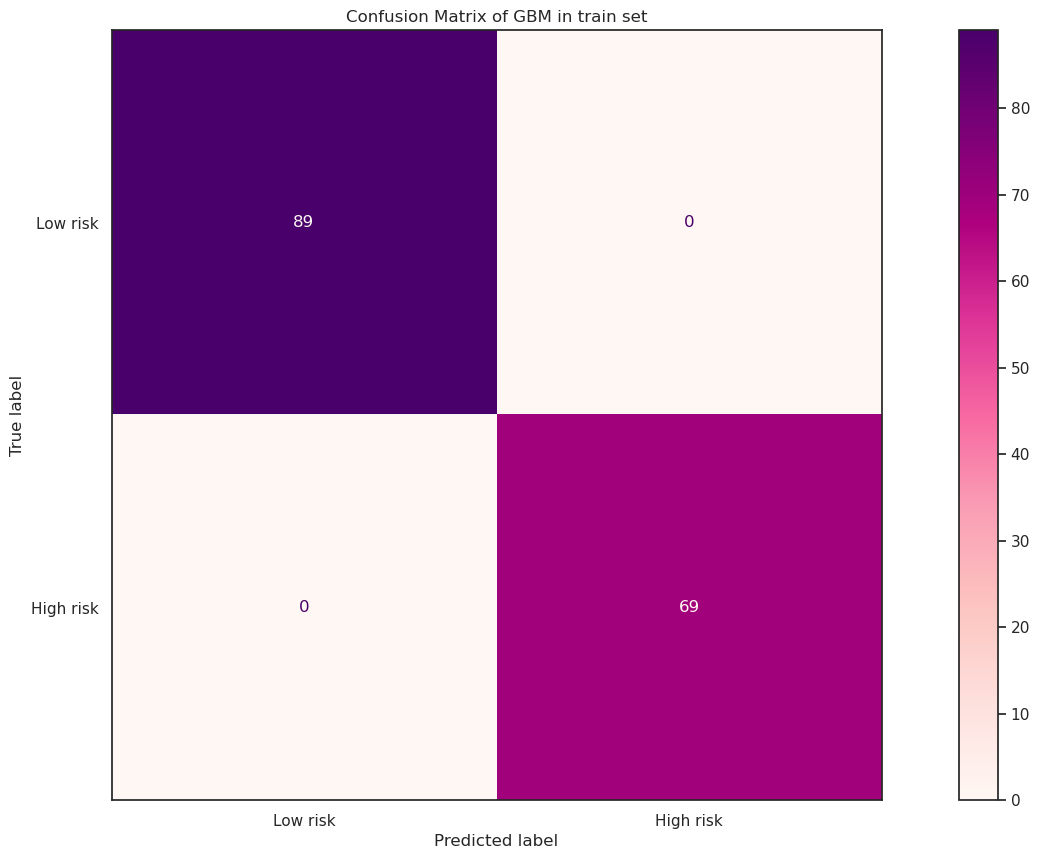

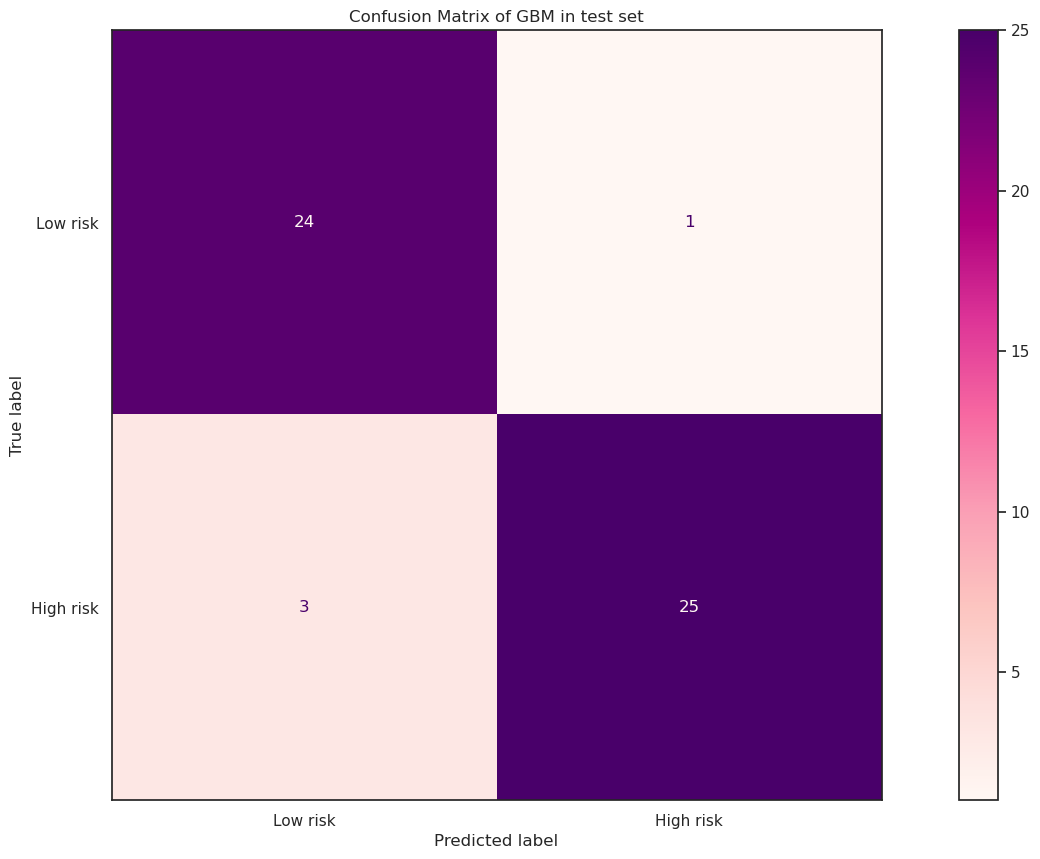

In [41]:
model = gbm_model    
  
# 创建一个图形和两个子图  
#训练集
mlp_prob_train = model.predict(X_train)  
cm = confusion_matrix(y_train, mlp_prob_train)  
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Low risk', 'High risk'])  
sns.set_style("white")  
disp.plot(cmap='RdPu') 
plt.title("Confusion Matrix of GBM in train set")
plt.savefig('训练集混淆矩阵.pdf',format='pdf')
plt.show()

#测试集
mlp_prob_test = model.predict(X_test)  
cm = confusion_matrix(y_test, mlp_prob_test)  
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Low risk', 'High risk'])  
sns.set_style("white")  
disp.plot(cmap='RdPu') 
plt.title("Confusion Matrix of GBM in test set")  
plt.savefig('测试集混淆矩阵.pdf',format='pdf') 
plt.show()

# 最佳模型五折ROC曲线

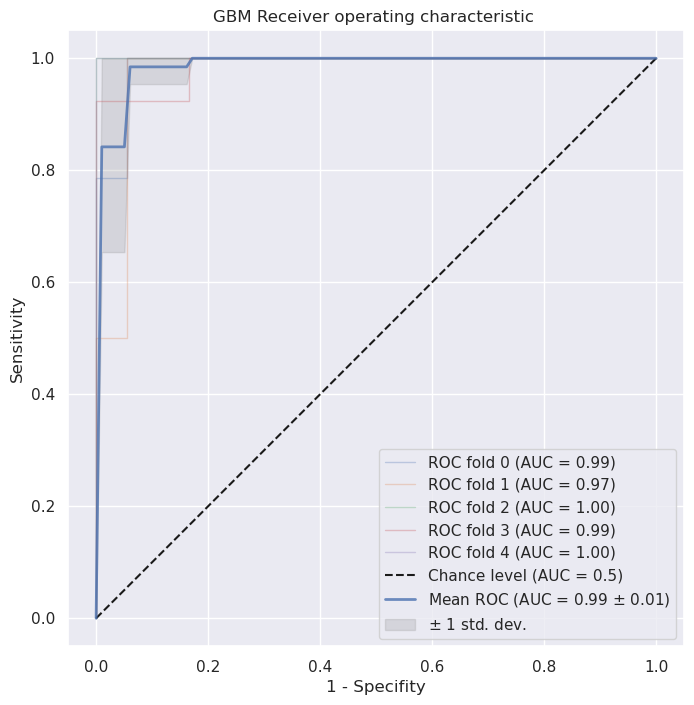

In [42]:
from sklearn.metrics import roc_auc_score, roc_curve, auc
sns.set()

n_splits = 5
cv = StratifiedKFold(n_splits=n_splits)
classifier = gbm_model #修改为性能最优的模型

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

X=X_train  #修改为相应的训练集数据
y=y_train

fig, ax = plt.subplots(figsize=(8, 8), dpi=100)
for fold, (train, test) in enumerate(cv.split(X, y)):
    classifier.fit(X.iloc[train], y.iloc[train])
    viz = RocCurveDisplay.from_estimator(
        classifier,
        X.iloc[test],
        y.iloc[test],
        name=f"ROC fold {fold}",
        alpha=0.3,
        lw=1,
        ax=ax,
        plot_chance_level=(fold == n_splits - 1),
    )
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(
    mean_fpr,
    mean_tpr,
    color="b",
    label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (mean_auc, std_auc),
    lw=2,
    alpha=0.8,
)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(
    mean_fpr,
    tprs_lower,
    tprs_upper,
    color="grey",
    alpha=0.2,
    label=r"$\pm$ 1 std. dev.",
)

ax.set(
    xlabel="False Positive Rate",
    ylabel="True Positive Rate",
    xlim=[-0.05, 1.05],
    ylim=[-0.05, 1.05],
    title="GBM Receiver operating characteristic ", #选择最佳机器学习模型
    # title=f"Mean ROC curve with variability\n(Positive label 'pulmary infection')", 
)
ax.legend(loc="lower right")
plt.xlabel("1 - Specifity")
plt.ylabel("Sensitivity")
plt.savefig('最佳模型五折ROC曲线.pdf',format='pdf')
plt.show()



# 模型在测试集中的性能展示

In [43]:
#针对测试集的评价指标矩阵
AB_model.fit(X_train, y_train)
lr_model.fit(X_train, y_train)
mlp_model.fit(X_train, y_train)
Bag_model.fit(X_train, y_train)
gbm_model.fit(X_train, y_train)
xgb_model.fit(X_train, y_train)

data_pingjia=pd.DataFrame(index = ['F1','AUC','accuracy','sensitivity','specificity'])  #设置行名
model_name = [AB_model,lr_model,Bag_model,mlp_model,gbm_model,xgb_model]

for i in range(len(model_name)):
    #计算F1值
    F1 = f1_score(y_test, model_name[i].predict(X_test), average='macro')
    #计算AUC
    fpr, tpr, thresholds = roc_curve(y_test, model_name[i].predict_proba(X_test)[:, 1])
    AUC = auc(fpr, tpr)
    #计算accuracy
    accuracy = model_name[i].score(X_test,y_test)
    #计算sensitivity和specificity
    TN, FP, FN, TP = confusion_matrix(y_test, model_name[i].predict(X_test)).ravel()
    sensitivity,specificity = round(TP/(TP+FN), 3), round(TN/(FP+TN), 3)
    data_pingjia[i]=[F1,AUC,accuracy,sensitivity,specificity]
data_pingjia.columns = ["AB",'LR','BAG','MLP','GBM','XGB']  #修改列名

# data_pingjia
data_pingjia.round(3)#保留小数位数
data_pingjia.T #数据转置

/home/gg/mambaforge/envs/xiaoli/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/home/gg/mambaforge/envs/xiaoli/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


,F1,AUC,accuracy,sensitivity,specificity
AB,0.811254,0.903571,0.811321,0.750,0.88
LR,0.320513,0.730000,0.471698,0.000,1.00
BAG,0.621429,0.729286,0.622642,0.536,0.72
MLP,0.773504,0.835714,0.773585,0.750,0.80
GBM,0.924501,0.980000,0.924528,0.893,0.96
XGB,0.905526,0.962857,0.905660,0.893,0.92


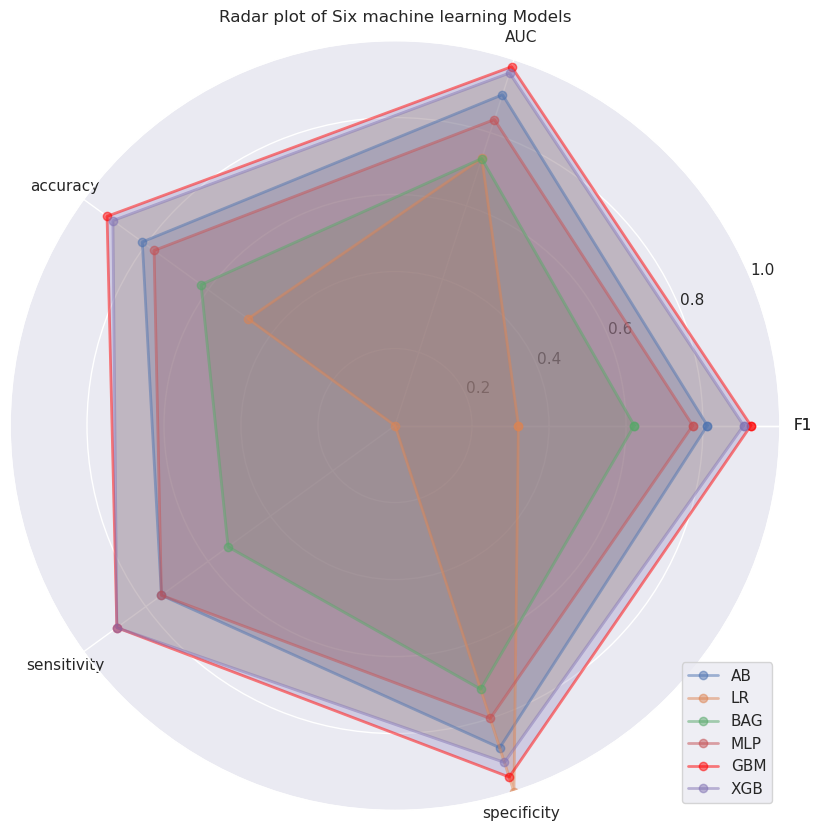

In [45]:
#绘制评价指标雷达图
values = data_pingjia.AB
values1 = data_pingjia.LR
values2 = data_pingjia.BAG
values3 = data_pingjia.MLP
values4 = data_pingjia.GBM
values5 = data_pingjia.XGB

S_labels = ['F1','AUC','accuracy','sensitivity','specificity','F1']  #最后一个一定要与第一个重合0和360的问题
# 设置每个数据点的显示位置，在雷达图上用角度表示
angles=np.linspace(0, 2*np.pi,len(values), endpoint=False)  #2*np.pi是2π的意思

# 拼接数据首尾，使图形中线条封闭
values=np.concatenate((values,[values[0]]))
values1=np.concatenate((values1,[values1[0]]))
values2=np.concatenate((values2,[values2[0]]))
values3=np.concatenate((values3,[values3[0]]))
values4=np.concatenate((values4,[values4[0]]))
values5=np.concatenate((values5,[values5[0]]))
angles=np.concatenate((angles,[angles[0]]))

# 绘图
fig=plt.figure()
# 设置为极坐标格式
ax = fig.add_subplot(111, polar=True)
# 绘制折线图
ax.plot(angles, values, 'o-', linewidth=2, alpha=0.5 ,label='AB')
ax.plot(angles, values1, 'o-', linewidth=2, alpha=0.5 ,label='LR')
ax.plot(angles, values2, 'o-', linewidth=2, alpha=0.5 ,label='BAG')
ax.plot(angles, values3, 'o-', linewidth=2, alpha=0.5 ,label='MLP')
ax.plot(angles, values4, 'o-', linewidth=2, alpha=0.5 ,label='GBM',color='red')
ax.plot(angles, values5, 'o-', linewidth=2, alpha=0.5,label='XGB')
# 填充颜色
ax.fill(angles, values, alpha=0.25)
ax.fill(angles, values1, alpha=0.25)
ax.fill(angles, values2, alpha=0.25)
ax.fill(angles, values3, alpha=0.25)
ax.fill(angles, values4, alpha=0.25)
ax.fill(angles, values5, alpha=0.25)
# 设置图标上的角度划分刻度，为每个数据点处添加标签
ax.set_thetagrids(angles * 180/np.pi,labels=S_labels)  #angles * 180/np.pi 将弧度转化为度数
 
# 设置雷达图的范围
ax.set_ylim(0,1)
# 添加标题
plt.title('Radar plot of Six machine learning Models') #Radar plot of Six machine learning Methods
# 添加网格线
ax.grid(True)
plt.legend(loc="lower right")
plt.savefig('模型在测试集中的性能展示-雷达图.pdf',format='pdf')
plt.show()


# 特征重要性SHAP-Perumation

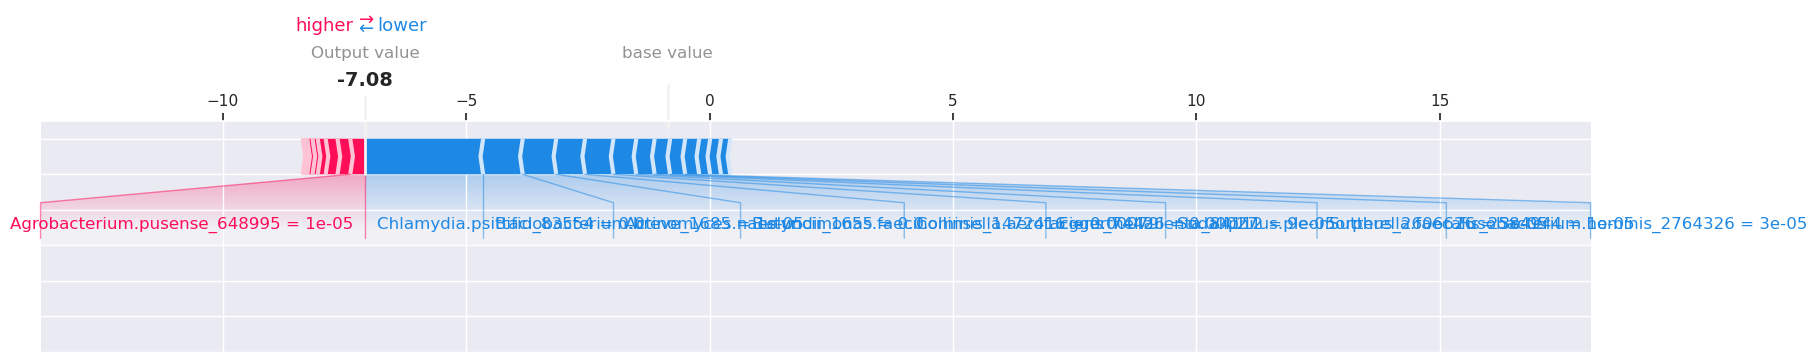

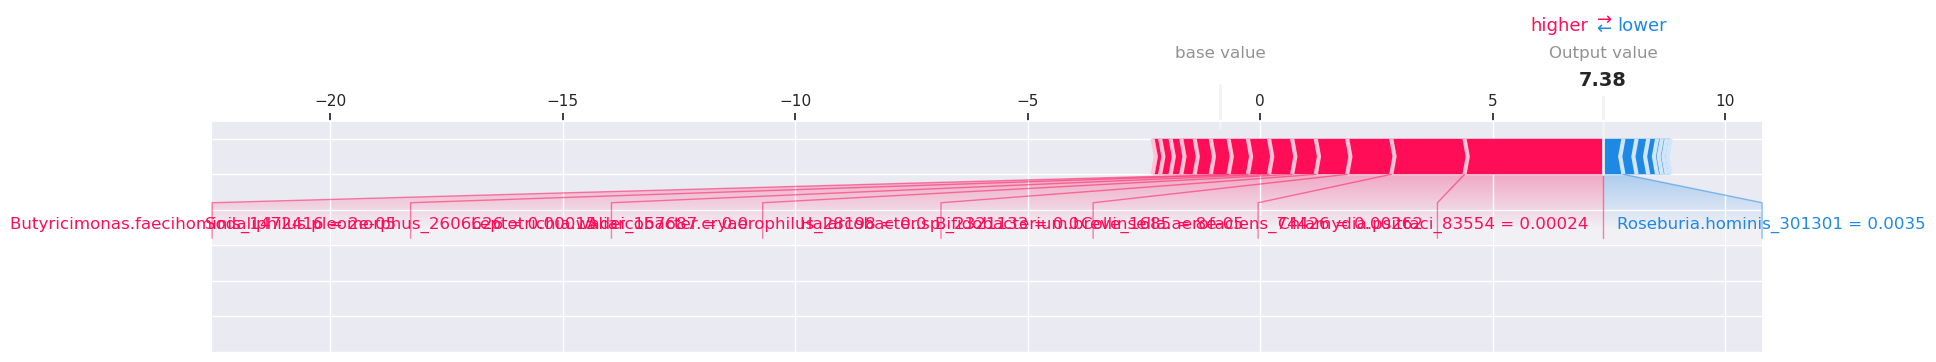

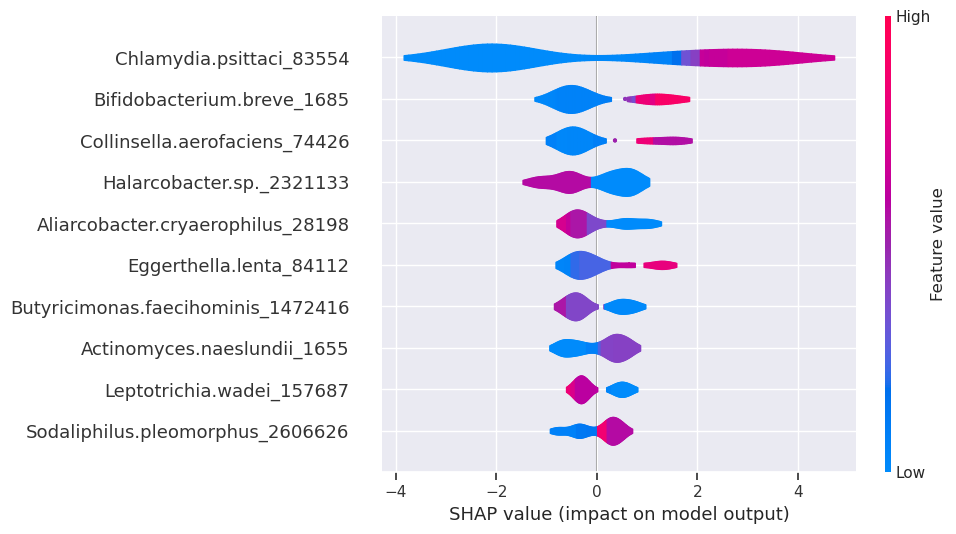

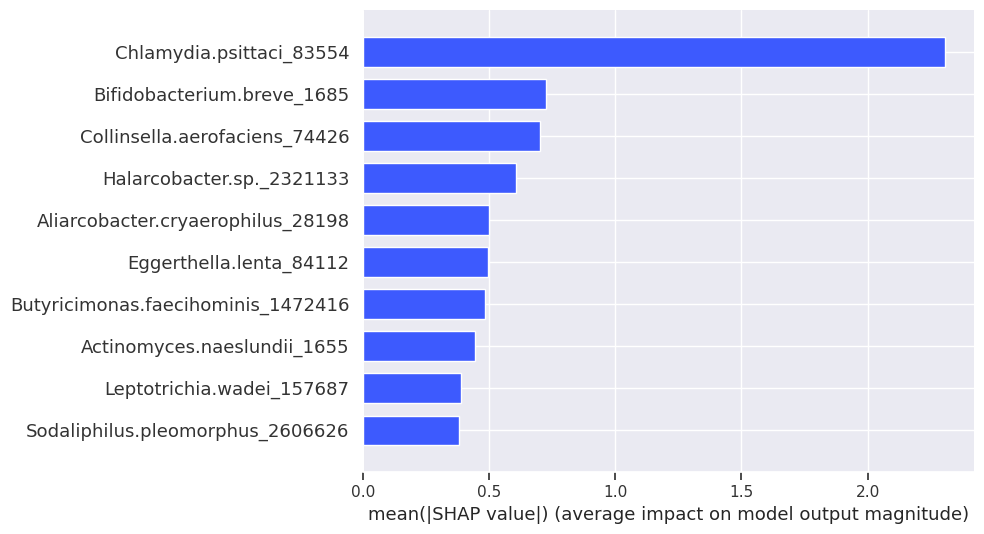

In [116]:
import shap

explainer = shap.Explainer(xgb_model,X_train)
shap_values = explainer(X_train)

#吴世楠绘制
#Feature importances1 and 2
a = 20
shap.plots.force(#explainer.expected_value,  #shap.force_plot
                shap_values[155],  #表示第 150 个样本的特征对模型输出的影响
                X_train.iloc[a, :], 
                # figsize=(30, 2.5),
                # link = "logit",
                matplotlib=True,
                out_names = "Output value",show=False)
plt.rcParams["figure.figsize"] = [30, 5]
plt.savefig('plot1.pdf',format='pdf')
plt.show()

a = 20
shap.plots.force(#explainer.expected_value,  #shap.force_plot
                shap_values[2], 
                X_train.iloc[a, :], 
                # figsize=(20, 2.5),
                # link = "logit",
                matplotlib=True,
                out_names = "Output value",show=False)
plt.rcParams["figure.figsize"] = [30, 5]
plt.savefig('plot2.pdf',format='pdf')
plt.show()

#Feature importances(吴世楠)
#violin
shap.summary_plot(shap_values, 
                  X_train,
                  plot_type="violin", 
                  max_display=10,
                  color='#3d5afe',
                  title='Feature importance',show=False,plot_size=(10,5.5))
# plt.title("Feature importance")
plt.savefig('violin.pdf',format='pdf')
plt.show()

#bar
shap.summary_plot(shap_values, 
                  X_train, 
                  plot_type="bar", 
                  color='#3d5afe',
                  title='Feature importance',max_display=10,show=False,plot_size=(10,5.5))
# plt.title("Feature importance")
plt.savefig('bar.pdf',format='pdf')
plt.show()

# ##Feature importances(刘文彩)
# shap.bar_plot(shap_values, features=None, feature_names=None, max_display=10, show=False)
# plt.title("Feature importance")
# plt.show()

<Axes: title={'center': 'Relative Feature Importances of XGB'}>

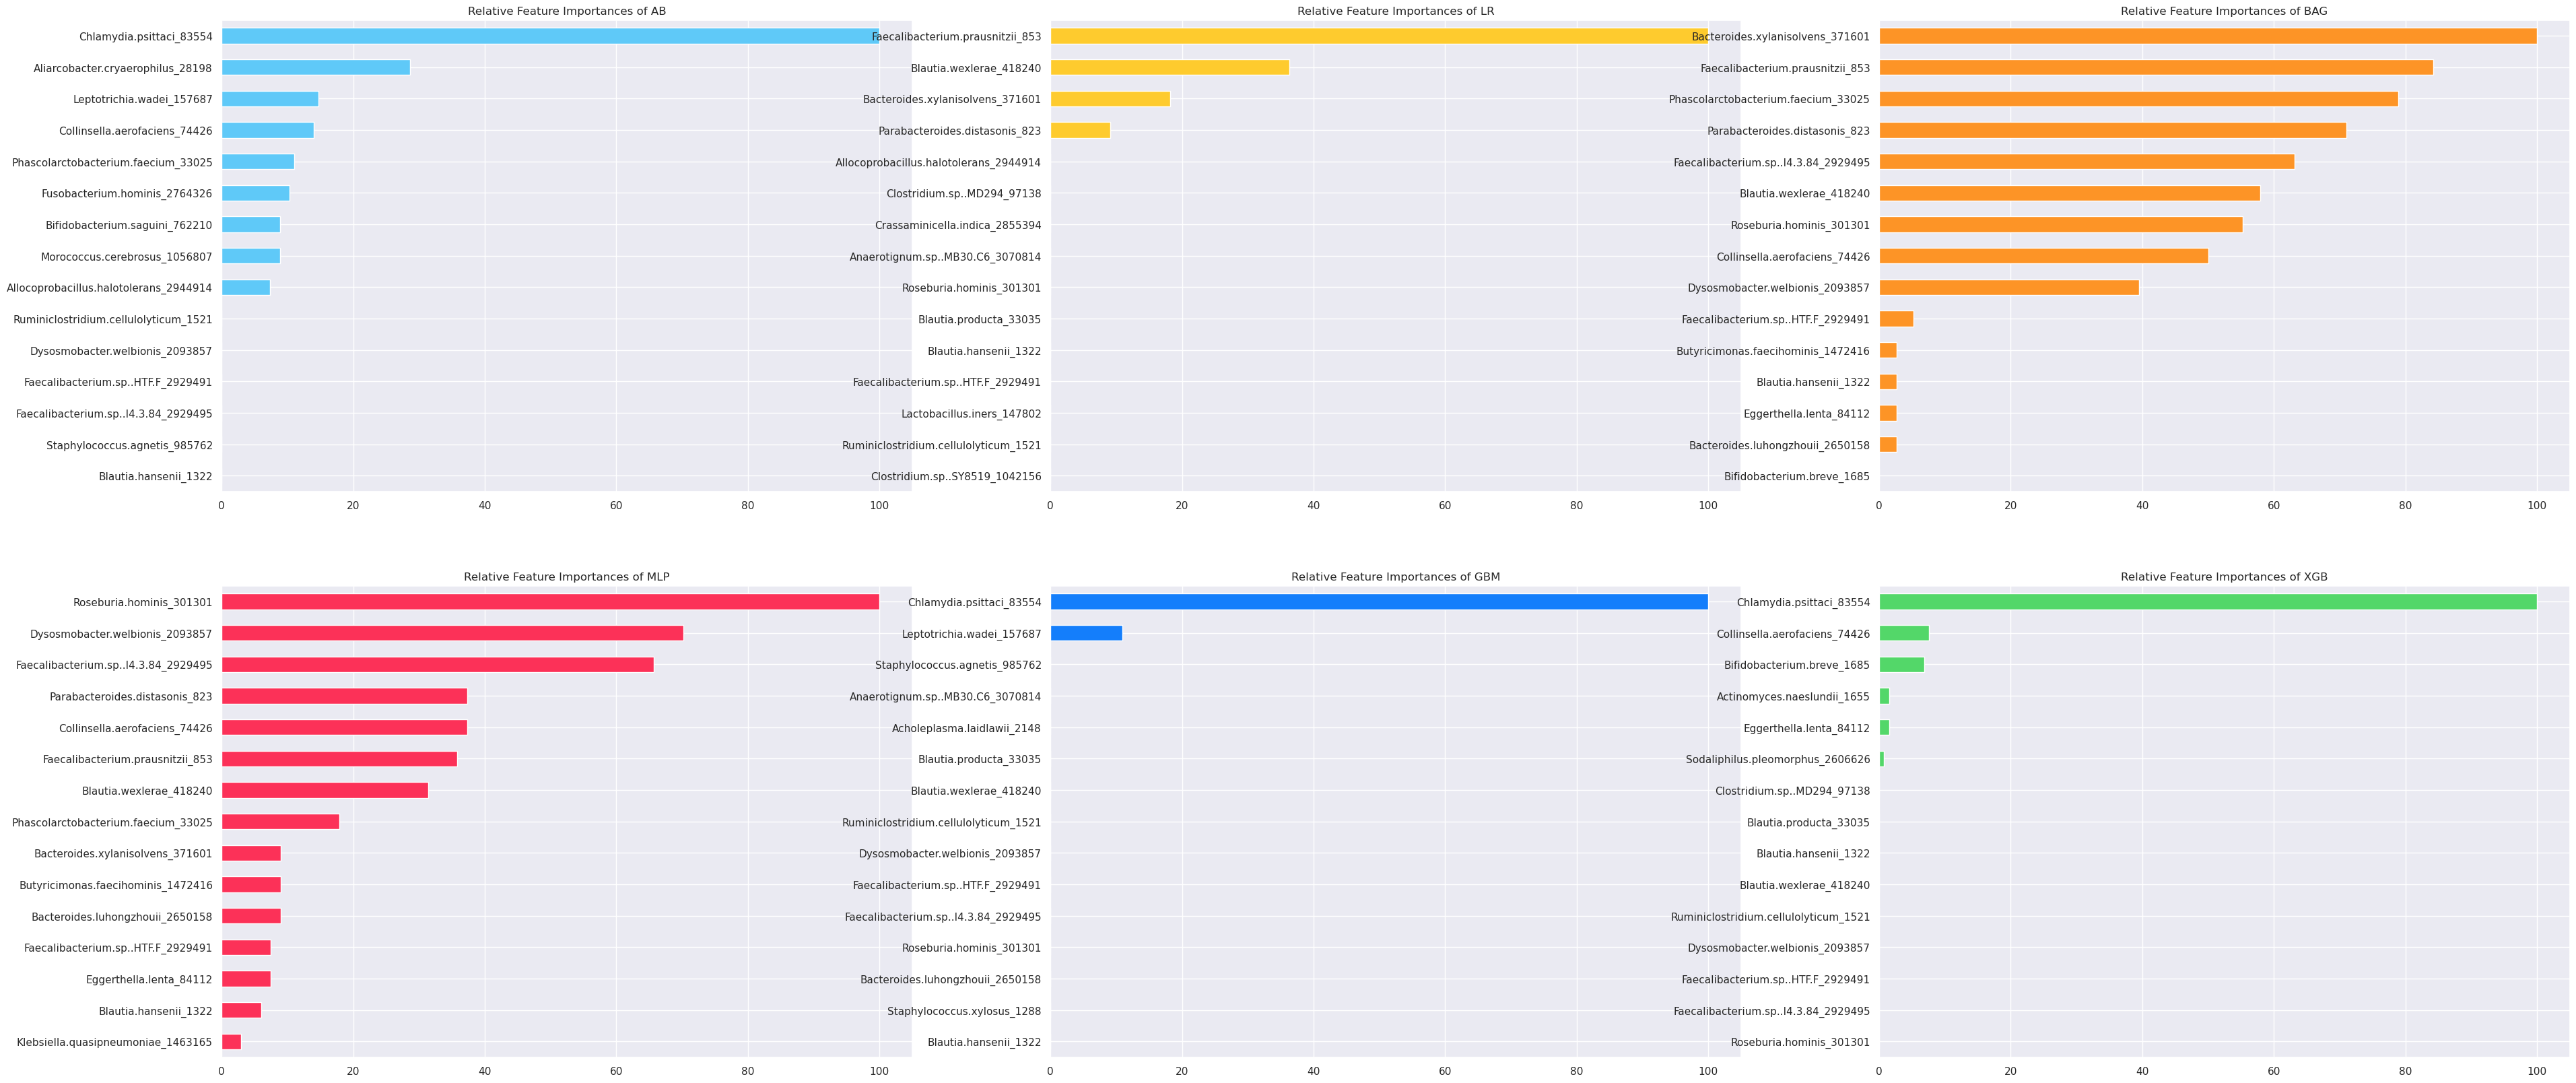

In [17]:
result = permutation_importance(AB_model,X_train, y_train, n_repeats=5,random_state=32)#,scoring='roc_auc')
result1 = permutation_importance(lr_model,X_train, y_train, n_repeats=5,random_state=32)#,scoring='roc_auc')
result2= permutation_importance(Bag_model,X_train, y_train, n_repeats=5,random_state=32)#,scoring='roc_auc')
result3 = permutation_importance(mlp_model,X_train, y_train, n_repeats=5,random_state=32)#,scoring='roc_auc')
result4 = permutation_importance(gbm_model,X_train, y_train, n_repeats=5,random_state=32)#,scoring='roc_auc')
result5 = permutation_importance(xgb_model,X_train, y_train, n_repeats=5,random_state=32)#,scoring='roc_auc')


plt.rcParams["figure.figsize"] = [45, 20]
features = X.columns

plt.subplot(231)
r_feat_imp = pd.Series(abs(100*(result.importances_mean)/result.importances_mean.max()), features).sort_values(ascending=True)
# r_feat_imp.plot(kind='barh', title='Relative Feature Importances of AB',color='#5fc9f8')
# 只取前15个最重要的特征  
r_feat_imp_sorted = r_feat_imp.sort_values(ascending=False)  # 先进行降序排序  
top_15_feat_imp = r_feat_imp_sorted.head(15).sort_values(ascending=True) 
top_15_feat_imp.plot(kind='barh', title='Relative Feature Importances of AB',color='#5fc9f8')


plt.subplot(232)
r_feat_imp = pd.Series(abs(100*result1.importances_mean/result1.importances_mean.max()), features).sort_values(ascending=True)
# r_feat_imp.plot(kind='barh', title='Relative Feature Importances of LR',color='#fecb2e')
r_feat_imp_sorted = r_feat_imp.sort_values(ascending=False)  # 先进行降序排序  
top_15_feat_imp = r_feat_imp_sorted.head(15).sort_values(ascending=True)  
top_15_feat_imp.plot(kind='barh', title='Relative Feature Importances of LR',color='#fecb2e')

plt.subplot(233)
r_feat_imp = pd.Series(abs(100*result2.importances_mean/result2.importances_mean.max()), features).sort_values(ascending=True)
# r_feat_imp.plot(kind='barh', title='Relative Feature Importances of BAG',color='#fd9426')
r_feat_imp_sorted = r_feat_imp.sort_values(ascending=False)  # 先进行降序排序  
top_15_feat_imp = r_feat_imp_sorted.head(15).sort_values(ascending=True)  
top_15_feat_imp.plot(kind='barh', title='Relative Feature Importances of BAG',color='#fd9426')

plt.subplot(234)
r_feat_imp = pd.Series(abs(100*result3.importances_mean/result3.importances_mean.max()), features).sort_values(ascending=True)
# r_feat_imp.plot(kind='barh', title='Relative Feature Importances of MLP',color='#fc3158')
r_feat_imp_sorted = r_feat_imp.sort_values(ascending=False)  # 先进行降序排序  
top_15_feat_imp = r_feat_imp_sorted.head(15).sort_values(ascending=True)  
top_15_feat_imp.plot(kind='barh', title='Relative Feature Importances of MLP',color='#fc3158')

plt.subplot(235)
r_feat_imp = pd.Series(abs(100*result4.importances_mean/result4.importances_mean.max()), features).sort_values(ascending=True)
# r_feat_imp.plot(kind='barh', title='Relative Feature Importances of GBM',color='#147efb')
r_feat_imp_sorted = r_feat_imp.sort_values(ascending=False)  # 先进行降序排序  
top_15_feat_imp = r_feat_imp_sorted.head(15).sort_values(ascending=True)  
top_15_feat_imp.plot(kind='barh', title='Relative Feature Importances of GBM',color='#147efb')

plt.subplot(236)
r_feat_imp = pd.Series(abs(100*result5.importances_mean/result5.importances_mean.max()), features).sort_values(ascending=True)
# r_feat_imp.plot(kind='barh', title='Relative Feature Importances of XGB',color='#53d769')
r_feat_imp_sorted = r_feat_imp.sort_values(ascending=False)  # 先进行降序排序  
top_15_feat_imp = r_feat_imp_sorted.head(15).sort_values(ascending=True)  
top_15_feat_imp.plot(kind='barh', title='Relative Feature Importances of XGB',color='#53d769')

# plt.savefig('feature_importances.pdf', format='pdf')  

# plt.close()